In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from tqdm.auto import tqdm
from time import sleep
pd.set_option('display.max_columns', None)

# Functions

In [2]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']
def get_first_line(file_path): #get first line 
    with open(file_path) as f:
        return f.readline()

def get_last_line(file_path): #faster way to get last line
    with open(file_path, 'rb') as file:
        try:
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)
        last_line = file.readline().decode()
        return last_line


def cut_output_files(directory):
    #function to get final periods of all txt files in 'directory'
    #output in numpy array of logP in days

    for filename in os.listdir(directory):
        if filename.endswith('.txt') and filename.startswith('output'):
            this_file = os.path.join(directory, filename) #stores FULL filename

            first_line = get_first_line(this_file) #get first line
            last_line = get_last_line(this_file) #get last line
            
            N = filename.split('.txt')[0].split('_')[1] #get the output file number
            with open(directory+'cut_files/first_last_{}.txt'.format(N), 'w') as f:
                f.write(first_line)
                f.write(last_line)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));

directory = '/Users/bijan1339/Desktop/Research/OSPEStellarEv_updated/outputs/'
#get_final_periods(directory)  
def maybe_float(s):
    try:
        return float(s)
    except (ValueError, TypeError):
        return s
def find_line(file,type1,type2=-1):
    """
    Goes through OSPE output file and finds last instance where there is an 
    inner binary with star types specified above (types from SSE).
    
    :param file: The first argument (string)
    :param type1: The second argument (integer)
    :param type2: The third argument. -1 means that the type can be any type (integer)
    :return: last line of occurence in file; line split into list and converted numbers to float (list)
    """
    if type2 == -1:
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]

            if (line[-6] == type1 or line[-7] == type1):
                return line
                break
    elif type1 == -1:
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]

            if (line[-6] == type2 or line[-6] == type2):
                return line
                break
                
    else: 
        for line in reversed(open(file).readlines()):
            line = [maybe_float(x) for x in line.split()]
            
            if ( (line[-6] == type1) and (line[-7] == type2) ) or ( (line[-6] == type2) and (line[-7] == type1) ): #order doesnt matter:
                return line
                break
k2 = 4*np.pi*np.pi

# Inner Binary Analyses

In [451]:
#GETTING RESTART FILESNAMES TO CONCATENATE WITH
directory = '/Users/bijan1339/Desktop/Research/Outputs/'

# The string to look for in the filenames
key = 'Re'

# Get a list of all the files in the directory
files = os.listdir(directory)

# Create an empty list to store the filenames that contain the string
restart_filenames = []

# Loop through the files and check if each one contains the string
for file in files:
    if key in file:
        restart_filenames.append(file)
#concatting old with restarted files
directory = '/Users/bijan1339/Desktop/Research/Outputs/'
for this_restart_file in restart_filenames:
    n = int(this_restart_file.split('.')[0].split('_')[1])
    # Define the names of the two files to be concatenated
    file1 = directory + f'output_{n}.txt'
    file2 = directory + this_restart_file

    # Open the files in read mode
    f1 = open(file1, "r")
    f2 = open(file2, "r")

    # Read the contents of the files
    contents1 = f1.read()
    contents2 = f2.read()

    # Concatenate the contents of the files
    concatenated_contents = contents1 + contents2

    # Define the name of the output file
    output_file = directory + f'concatenated_output_{n}.txt'

    # Open the output file in write mode
    f_out = open(output_file, "w")

    # Write the concatenated contents to the output file
    f_out.write(concatenated_contents)

    # Close the files
    f1.close()
    f2.close()
    f_out.close()

['outputRe_1118.txt', 'outputRe_1050.txt', 'outputRe_1078.txt', 'outputRe_1087.txt', 'outputRe_1084.txt']


In [12]:
###############################################
###########   MAKING DATAFRAME(s)  ############
###############################################
directory = '/Users/bijan1339/Desktop/Research/cut_files2/' #directory of output files
 #columns in output file
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1_pow','type1','type2','type3','beta2','gamma','gamma2','flag'] #columns in output file

df_columns = ['N'] + columns
initial = pd.DataFrame(columns=df_columns)
final = pd.DataFrame(columns=df_columns)
#first_line,last_line='',''
not_finished=[]
for filename in os.listdir(directory):
    not_done_flag=0
    n = filename.split('_')[-1].split('.')[0]
    
    if ( 
        filename.endswith('.txt') and (filename.startswith('first_') or filename.startswith('concatenated_')) and 
        ( (1000 <= int(n) < 1400) or (1500 < int(n) < 2000) )
       ):
        #n = filename.split('_')[-1].split('.')[0]
        
        this_file = os.path.join(directory, filename) #stores FULL filename

        first_line = get_first_line(this_file).replace('\x00','') #get first line
        last_line = get_last_line(this_file).replace('\x00','') #get last line 

        first_line, last_line = first_line.split('\t'), last_line.split('\t')
        first_line, last_line  = [x.strip() for x in first_line],[x.strip() for x in last_line] #remove white spaces (' ' and '\n')
        #first_line, last_line  = [float(x) for x in first_line[:-1]],[float(x) for x in first_line[:-1]]
        first_line.insert(0,n),last_line.insert(0,n)
        
        a = float(last_line[df_columns.index('a1')]) #store final SMA (in AU)
        a2 = float(last_line[df_columns.index('a2')])
        e = float(last_line[df_columns.index('e1')]) #store final e (in AU)
        e2 = float(last_line[df_columns.index('e2')]) #store final e (in AU)
        R1,R2 = float(last_line[df_columns.index('R1')]), float(last_line[columns.index('R2')])
        m1,m2 = float(last_line[df_columns.index('m1')]), float(last_line[columns.index('m2')])
        t = float(last_line[df_columns.index('t')])
        P = np.sqrt(a**3 / (m1+m2) )*365.25;
        
        Roche1=Roche_limit(m1/m2)
        Roche2=Roche_limit(m2/m1)
        Roche1_criteria = R1 > (a*(1-e)*Roche1)
        Roche2_criteria = R2 > (a*(1-e)*Roche2)
        tidal_locking = (e <= 5e-5 and P*365.25<=7.) #and float(last_line[columns.index('sur')])== 4. #tidal locking if sur==4
        time_criteria = t >= 1e10 # check if until time completion
        epsilon_criteria = (a*e2)/(a2*(1-e2**2)) > 0.1 # essentially stability criteria
        major_criteria = first_line==last_line
        
        #end_criteria = last_line[-1] =='END'
        unfinished = not time_criteria and not (Roche1_criteria or Roche2_criteria or epsilon_criteria or tidal_locking)
        finished =  last_line[-1] == 'END' or float(last_line[3]) > 10e9
        
        initial.loc[len(initial)]=first_line
        final.loc[len(final)]=last_line

for i in range(1,len(final.columns)-1):
    final.iloc[:, i] = final.iloc[:, i].astype(float)
    initial.iloc[:, i] = initial.iloc[:, i].astype(float)
    
#add row of periods (days)
def get_inner_period_row(row):
    '''returns period in DAYS from df row'''
    return np.sqrt(row['a1']**3 / ( (row['m1']+row['m2']) )  )*365.25;
def get_outer_period_row(row):
    '''returns period in DAYS from df row'''
    return np.sqrt(row['a2']**3 / ((row['m1']+row['m2']+row['m3'])) )*365.25;
def get_logg(row, G = k2):
    '''returns log(g) for m1,m2 from df row'''
    g1 = G*row['m1']/(row['R1']*row['R1'])
    g2 = G*row['m2']/(row['R2']*row['R2'])
    return [np.log10(g1), np.log10(g2)]

final['P_in'] = final.apply(lambda row: get_inner_period_row(row), axis=1)
final['P_out'] = final.apply(lambda row: get_outer_period_row(row), axis=1)
initial['P_in'] = initial.apply(lambda row: get_inner_period_row(row), axis=1)
initial['P_out'] = initial.apply(lambda row: get_outer_period_row(row), axis=1)

final['logg_m1'] = final.apply(lambda row: get_logg(row)[0], axis=1)
final['logg_m2'] = final.apply(lambda row: get_logg(row)[1], axis=1)
initial['logg_m1'] = initial.apply(lambda row: get_logg(row)[0], axis=1)
initial['logg_m2'] = initial.apply(lambda row: get_logg(row)[1], axis=1)

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73612/4046676079.py:64: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final.iloc[:, i] = final.iloc[:, i].astype(float)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73612/4046676079.py:65: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  initial.iloc[:, i] = initial.iloc[:, i].astype(float)


In [13]:
################################################################
############       MAKING BINARY DATAFRAMES      ##############
##############################################################

cassini_n = [1002, 1003, 1010, 1027, 1027, 1031, 1065, 1065, 1084, 1088, 1088, 1165, 1165, 1166, 1166, 
            1170, 1202, 1207, 1245, 1245, 1247, 1256, 1256, 1259, 1259, 1273, 1273, 1280, 1280, 1309, 1325, 1389, 
            1531, 1547, 1556, 1588, 1631, 1652, 1656, 1672, 1675, 1693, 1703, 1758, 1796, 1807, 1809, 1867, 1876, 
            1887, 1903, 1994]
a = input('Are you sure that you want to run this cell? (y/n)')

if a == 'y':
    print('Ok, Lets Go!')

    full_outputs_directory = '/Users/bijan1339/Desktop/Research/Outputs/'

    all_binary_types = pd.DataFrame(columns= df_columns + ['binary_type'])

    for filename in tqdm(os.listdir(full_outputs_directory)):
        lines_to_add=[]
        line_MSMS = None
        line_RGRG = None
        line_WDWD = None
        line_RGWD = None
        line_RGMS = None
        line_WDMS = None
        line_RG_ = None
        line_WD_ = None
 
        
        is_MS1 = True
        is_MS2 = True
        is_RG1 = True
        is_RG1 = True
        is_WD1 = True
        is_WD2 = True
        cant_have_RG = False
        cant_have_WD = False
        
        n = maybe_float( filename.split('_')[-1].split('.')[0] )
        this_file = full_outputs_directory + filename
        if  (filename.startswith('output') or filename.startswith('concatenated') and len(last_line) != 1
            ):
            last_line = get_last_line(this_file)#.replace('\x00','') #get last line 
            last_line = last_line.split('\t')
            last_line  = [maybe_float(x.strip()) for x in last_line] #remove white spaces and float all indices

        if  ( 
            (filename.startswith('output_') or filename.startswith('concatenated_')) and 
            (type(n) == float and len(last_line) != 1) and 
            ( (0 <= int(n) < 1400) or (1500 < int(n) < 2000) or int(n) in cassini_n)  
            ):


            #Creating preliminary flags so that we dont need to loop through entire file if not necessary
#             if last_line[-7] < 1.: 
#                 is_MS1 = False
#             if last_line[-6] < 1.: 
#                 is_MS2 = False

            if last_line[-7] < 5.:
                is_WD1 = False
                is_RG1 = False
            if last_line[-6] < 5.:
                is_WD2 = False
                is_RG2 = False
            
            if last_line[-6] < 5. and last_line[-7] < 5.: cant_have_RG = True
            if last_line[-6] < 11. and last_line[-7] < 11.: cant_have_WD = True
                
            if is_MS1 and is_MS2:
                line_MSMS = find_line(this_file,1.,1.)
                if line_MSMS is None: line_MSMS = find_line(this_file,0.,1.)
                if line_MSMS is None: line_MSMS = find_line(this_file,0.,0.)
                    
            if is_RG1 and is_RG2:
                line_RGRG = find_line(this_file,5.,5.)
            if is_WD1 and is_WD2:
                line_WDWD = find_line(this_file,11.,11.)
            if (is_RG1 or is_RG2) and (is_WD1 or is_WD2):        
                line_RGWD = find_line(this_file,5.,11.)
            if not cant_have_RG:
                line_RG_ = find_line(this_file,5.,-1)
                line_RGMS = find_line(this_file,5.,1.)
                if line_RGMS is None: line_RGMS = find_line(this_file,5.,0.)
            if not cant_have_WD:
                line_WD_ = find_line(this_file,11.,-1)
                line_WDMS = find_line(this_file,11.,1.)
                if line_WDMS is None: line_WDMS = find_line(this_file,11.,0.)
                            
            if line_MSMS is not None: lines_to_add.append( line_MSMS + ['MSMS'] )
            if line_RGRG is not None: lines_to_add.append( line_RGRG + ['RGRG'] )
            if line_WDWD is not None: lines_to_add.append( line_WDWD + ['WDWD'] ) 
            if line_RGWD is not None: lines_to_add.append( line_RGWD + ['RGWD'] ) 
            if line_RGMS is not None: lines_to_add.append( line_RGMS + ['RGMS'] ) 
            if line_WDMS is not None: lines_to_add.append( line_WDMS + ['WDMS'] ) 

            if line_RG_ is not None and ( line_RG_ != (line_RGWD or line_RGRG or line_RGMS) ):
                lines_to_add.append( line_RG_ + ['RG_'] )
            if line_WD_ is not None and ( line_WD_ != (line_WDWD or line_RGWD or line_WDMS) ):
                lines_to_add.append( find_line(this_file,11.,-1) + ['WD_'] )  

            for l in lines_to_add:            
                try:
                    all_binary_types.loc[len(all_binary_types)]= [int(n)] + l
                except ValueError:
                    pass

    all_binary_types['P_in'] = all_binary_types.apply(lambda row: get_inner_period_row(row), axis=1)
    all_binary_types['P_out'] = all_binary_types.apply(lambda row: get_outer_period_row(row), axis=1)

else: print('Good Choice!')

Ok, Lets Go!


 37%|███▋      | 1072/2921 [06:50<01:41, 18.19it/s] 

In [6]:
def get_m1_condition(df):
    return ( (df['N'].astype(int)>1000) & (df['N'].astype(int)<=2000) ) #only returns 1m intial mass runs
def get_Omega_p(row):
    beta = row['beta']*np.pi/180.
    beta2 = row['beta2']*np.pi/180.
    omega_1 = (4*np.pi/row['P_in'] ) / (np.cos(beta) + (1/np.cos(beta)) )   
    omega_2 = (4*np.pi/row['P_in'] ) / (np.cos(beta2) + (1/np.cos(beta2)) )   
    return [2*np.pi/omega_1,2*np.pi/omega_2] #returns expected spin periods in days

def get_spin_periods(row):
    spin1P_radyr = np.sqrt(row['spin1h']**2.+row['spin1e']**2.+row['spin1q']**2.)
    spin2P_radyr = np.sqrt(row['spin2h']**2.+row['spin2e']**2.+row['spin2q']**2.)
    spin1P = 2.*np.pi*365.25/spin1P_radyr
    spin2P = 2.*np.pi*365.25/spin2P_radyr
    return [spin1P,spin2P]

m1_condition_final = get_m1_condition(df_final)

df_final = final[( (final['flag']=='END') | (final['t'] > 10e9) ) &  get_m1_condition(df_final)]#& (final['N'].astype(float) <=200)]
df_initial = initial[initial['N'].isin(df_final['N'])]

df_final_salpeter = df_final[df_final['N'].astype(int)<1000]
df_initial_salpeter = df_initial[df_initial['N'].isin(df_final_salpeter['N'])]

df_final_1m = df_final[m1_condition_final]
df_initial_1m = df_initial[df_initial['N'].isin(df_final_1m['N'])]

unf_final = final[(final['flag']!='END') & (final['t']!='0')]
unf_initial = initial[initial['N'].isin(unf_final['N'])]


close_df_final = df_final[(df_final['P_in'] <= 16.) & (df_final['sur'] !=0) & get_m1_condition(close_df_final)]
close_df_final['Omega_p1'] = close_df_final.apply(lambda row: get_Omega_p(row)[0], axis=1)
close_df_final['Omega_p2'] = close_df_final.apply(lambda row: get_Omega_p(row)[1], axis=1)
close_df_final['Spin1P'] = close_df_final.apply(lambda row: get_spin_periods(row)[0], axis=1)
close_df_final['Spin2P'] = close_df_final.apply(lambda row: get_spin_periods(row)[1], axis=1)

close_df_initial = df_initial[df_initial['N'].isin(close_df_final['N'])] 

merged_df_final = df_final[(df_final['sur']==0) & get_m1_condition(merged_df_final)]
merged_df_initial = df_initial[df_initial['N'].isin(merged_df_final['N'])]

MSMS = all_binary_types[(all_binary_types['binary_type'] == 'MSMS') & (all_binary_types['t'] != 0.) & get_m1_condition(MSMS)].drop_duplicates('N',keep='first')
WDWD = all_binary_types[(all_binary_types['binary_type'] == 'WDWD') & get_m1_condition(WDWD)].drop_duplicates('N',keep='first')
RGRG = all_binary_types[(all_binary_types['binary_type'] == 'RGRG') & get_m1_condition(RGRG)].drop_duplicates('N',keep='first')
RGWD = all_binary_types[(all_binary_types['binary_type'] == 'RGWD') & get_m1_condition(RGWD)].drop_duplicates('N',keep='first')
WDMS = all_binary_types[(all_binary_types['binary_type'] == 'WDMS') & get_m1_condition(WDMS)].drop_duplicates('N',keep='first')
RGMS = all_binary_types[(all_binary_types['binary_type'] == 'RGMS') & get_m1_condition(RGMS)].drop_duplicates('N',keep='first')
RG_ = all_binary_types[(all_binary_types['binary_type'] == 'RG_') & get_m1_condition(RG_)].drop_duplicates('N',keep='first')
WD_ = all_binary_types[(all_binary_types['binary_type'] == 'WD_') & get_m1_condition(WD_)].drop_duplicates('N',keep='first')

percent_close = (len(close_df_final) / len(df_final) ) *100
percent_merged = (len(merged_df_final)/ len(df_final) ) *100

print(f'Percent of Close Binaries: {round(percent_close,2)}% ({len(close_df_final)}/{len(df_final)}) ')
print(f'Percent of Mergers: {round(percent_merged,2)}% ({len(merged_df_final)}/{len(df_final)})')
print(f'Number of Salpeter Runs: {len(df_final_salpeter)}')
print(f'Number of 1 M Runs: {len(df_final_1m)}')

print(all_binary_types['binary_type'].value_counts())

NameError: name 'df_final' is not defined

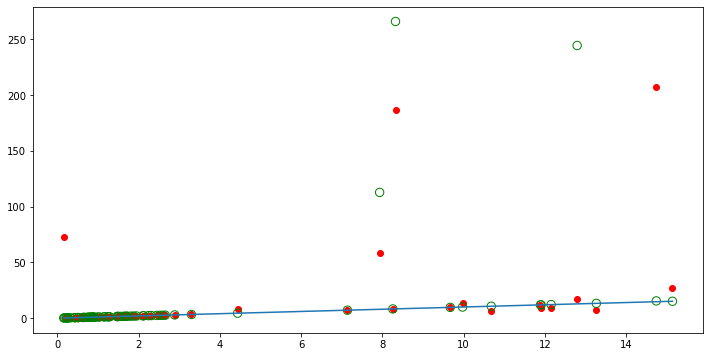

In [2552]:
close_df_final
#(close_df_final['Spin1P'] <= 1.10*close_df_final['P_in']) & (close_df_final['Spin1P'] >=0.9*close_df_final['P_in']) 
x = np.linspace(np.min(close_df_final['P_in']),np.max(close_df_final['P_in']),1000)
plt.plot(x,x)
plt.scatter(close_df_final['P_in'],close_df_final['Spin2P'],c='r')
#plt.scatter(close_df_final['P_in'],close_df_final['Omega_p2'],c='g')
plt.scatter(close_df_final['P_in'],close_df_final['Omega_p2'],facecolors='none', edgecolors='g',s=70)

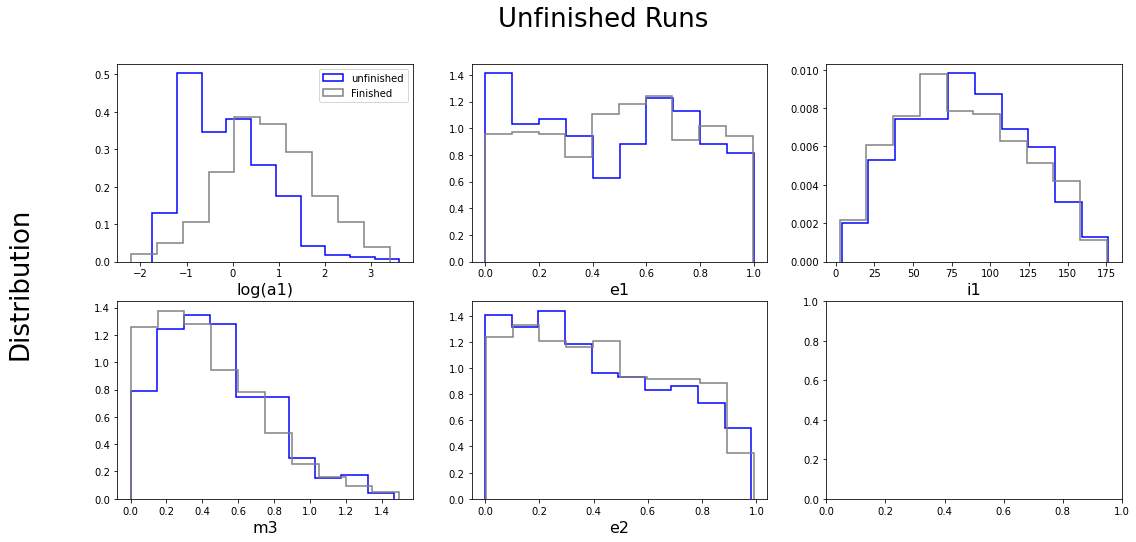

In [2449]:
#################################################
###########  UNFINISHED SIMULATIONS  ############
#################################################

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))


ax1.hist(np.log10(unf_initial['a1']),histtype='step',density=True,linewidth=1.5,color='b',label='unfinished')
ax1.hist(np.log10(df_initial['a1']),histtype='step',density=True,linewidth=1.5,color='gray',label='Finished')

ax2.hist(unf_initial['e1'],histtype='step',density=True,linewidth=1.5,color='b')
ax2.hist(df_initial['e1'],histtype='step',density=True,linewidth=1.5,color='gray')

ax3.hist(unf_initial['i1'],histtype='step',density=True,linewidth=1.5,color='b')
ax3.hist(df_initial['i1'],histtype='step',density=True,linewidth=1.5,color='gray')

ax4.hist(unf_initial['m3']/(unf_initial['m1']+unf_initial['m2']),histtype='step',density=True,linewidth=1.5,color='b')
ax4.hist(df_initial['m3']/(df_initial['m1']+df_initial['m2']),histtype='step',density=True,linewidth=1.5,color='gray')

ax5.hist(unf_initial['e2'],histtype='step',density=True,linewidth=1.5,color='b')
ax5.hist(df_initial['e2'],histtype='step',density=True,linewidth=1.5,color='gray')
fig.suptitle('Unfinished Runs',fontsize=26)
fig.text(0.04, 0.5, 'Distribution', va='center', rotation='vertical',fontsize=26)

ax1.set_xlabel('log(a1)',fontsize=16), ax2.set_xlabel('e1',fontsize=16),ax3.set_xlabel('i1',fontsize=16)
ax4.set_xlabel('m3',fontsize=16), ax5.set_xlabel('e2',fontsize=16)
ax1.legend()
plt.show()

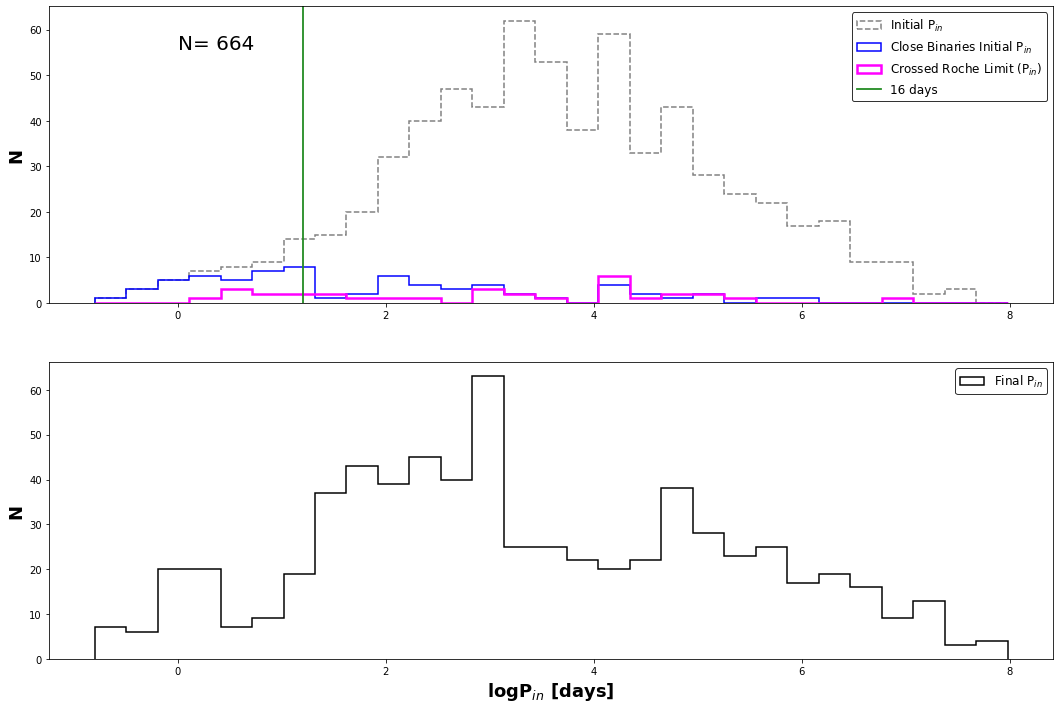

In [2450]:
def get_period(a,m1,m2,m3=0):
    '''returns period in days'''
    return np.sqrt(a**3 / (m1+m2+m3) )*365.25;

# df_final = df_final[np.int32(df_final['N']) >3000]
# df_initial = df_initial[np.int32( df_initial['N'] )>3000]
# close_df_initial = close_df_initial[np.int32(close_df_initial['N']) >3000]
# close_df_final = close_df_final[np.int32(close_df_final['N']) >3000]
df_final = df_final[(df_final['N'].astype(int) < 2000) & (df_final['N'].astype(int) > 1000)]
Roche1=Roche_limit(df_final['m1']/df_final['m2'])
Roche2=Roche_limit(df_final['m2']/df_final['m1'])
Roche1_criteria = df_final['R1'] > (df_final['a1']*(1-df_final['e1'])*Roche1)
Roche2_criteria = df_final['R2'] > (df_final['a1']*(1-df_final['e1'])*Roche2)

initial_periods = np.log10(df_initial['P_in'])
final_periods = np.log10(df_final['P_in'])
close_binaries = np.log10(close_df_initial['P_in'])
roche_binaries = df_final[(df_final['sur'] == 0) | (df_final['sur2'] == 0)]
roche_periods = np.log10(df_initial[df_initial['N'].isin(roche_binaries['N'])]['P_in'])

fig, ((ax1,ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))

bins1 = np.linspace(np.min(initial_periods),np.max(initial_periods),16)
bins2 = np.linspace(np.min(final_periods),np.max(final_periods),30)

n,b,p = ax1.hist(initial_periods,bins=bins2,color='gray',density=False,label='Initial P$_{in}$',histtype='step',linestyle='--',linewidth=1.5,stacked=False)
ax2.hist(final_periods,bins=bins2,density=False,label='Final P$_{in}$',histtype='step', linewidth=1.5,color='black')
ax1.hist(close_binaries,bins=bins2,label='Close Binaries Initial P$_{in}$',histtype='step',color='blue',linewidth=1.5,density=False)
ax1.hist(roche_periods,bins=bins2,density=False,label='Crossed Roche Limit (P$_{in}$)',histtype='step',linewidth=2.5,color='magenta')

ax1.axvline(np.log10(16),color='forestgreen',alpha=1.0,linewidth=1.8,label='16 days')
ax2.set_xlabel('logP$_{in}$ [days]',fontsize=18,fontweight='bold')
ax1.set_ylabel('N',fontsize=18,fontweight='bold'), ax2.set_ylabel('N',fontsize=18,fontweight='bold')
ax1.legend(edgecolor="black", prop={'size': 12}), ax2.legend(edgecolor="black", prop={'size': 12}) #bbox_to_anchor=(0.6, 0.75)
ax1.text(0,np.max(n)*0.9,'N= '+str(len(initial_periods)),fontsize=20) 

#plt.savefig('/Users/bijan1339/Desktop/Research/Figures/period_distribution_upd.pdf')
plt.show()

/Users/bijan1339/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


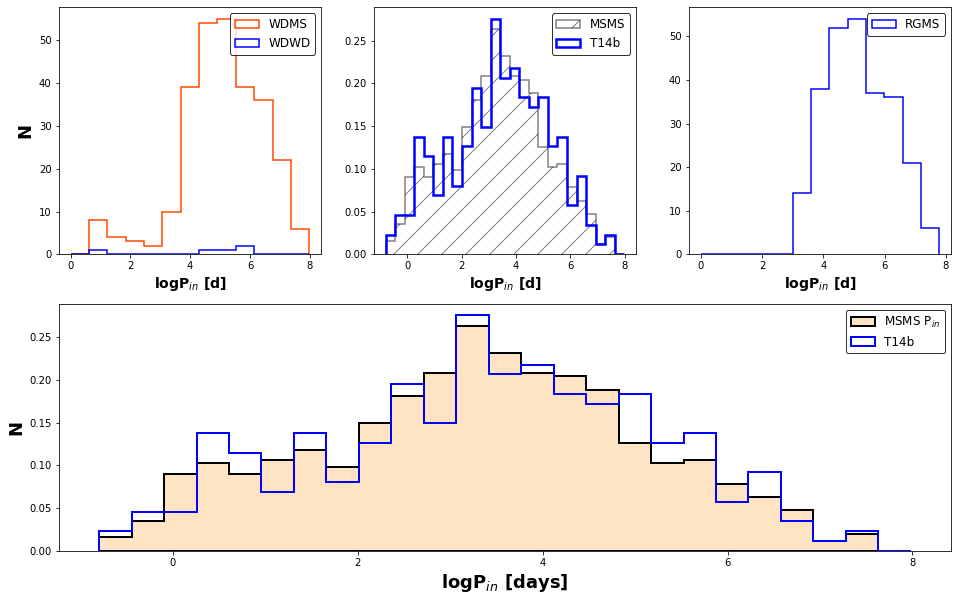

In [2496]:
plt.figure(figsize=(16, 10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)

t14a_bin_trip = t14a[(t14a['Nc'] == '2') | (t14a['Nc'] == '3')]

minWD,maxWD = np.min( np.log10(WDMS['P_in'])  ), np.max( np.log10(WDMS['P_in'])  )
minRG,maxRG = np.min( np.log10(RGMS['P_in'])  ), np.max( np.log10(RGMS['P_in'])  )
mint14a,maxt14a = 0, np.max( np.log10(t14a_bin_trip['Period'])  )

binsWD = np.linspace(0,maxWD,14)
binsRG = np.linspace(0,maxRG,14)
binst14a = np.linspace(mint14a,maxt14a,14)
final_periods = np.log10(df_final['P_in'])
bins2 = np.linspace(np.min(final_periods),np.max(final_periods),26)

#ax1.hist(np.log10(WD_['P_in']),bins=binsWD,density=False,label='WD_',histtype='step', linewidth=1.5,color='gray',linestyle='--')
ax1.hist(np.log10(WDMS['P_in']),bins=binsWD,density=False,label='WDMS',histtype='step', linewidth=1.5,color='orangered',cumulative=False)
ax1.hist(np.log10(WDWD['P_in']),bins=binsWD,density=False,label='WDWD',histtype='step', linewidth=1.5,color='b')

#ax3.hist(np.log10(RG_['P_in']),bins=binsRG,density=False,label='RG_',histtype='step', linewidth=1.5,color='gray',linestyle='--')
ax3.hist(np.log10(RGMS['P_in']),bins=binsRG,density=False,label='RGMS',histtype='step', linewidth=1.5,color='b')

#ax2.hist(np.log10(RGWD['P_in']),bins=binst14a,density=True,label='RGWD',histtype='step', linewidth=1.5,color='r',cumulative=True)
MSMS_1m = MSMS[(MSMS['N'].astype(int) > 1000) & (MSMS['N'].astype(int) < 2000)]
ax2.hist(np.log10(MSMS['P_in']),bins=bins2,density=True,label='MSMS',histtype='step', 
         linewidth=1.5,color='c',cumulative=False,edgecolor='k', hatch='/',alpha=0.5)
#ax2.hist(yc,histtype='step',linewidth=2.0,bins=bins2, density=True,label='T17',color='orangered',cumulative=False,alpha=0.4)
ax2.hist(yb,histtype='step',linewidth=2.5,bins=bins2, density=True,label='T14b',color='b',cumulative=False)

y = np.log10(t14a_bin_trip[t14a_bin_trip['Period'] != 0 ]['Period']).replace(-np.inf, 0)
yb = t14b_inner['logP']
yc = np.log10(t17_inner['P'] *365.25)

ax4.hist(np.log10(MSMS['P_in']),bins=bins2,density=True,label='MSMS P$_{in}$', linewidth=2.0,
         facecolor='bisque',edgecolor='black',histtype='stepfilled')
#ax4.hist(yc,histtype='step',linewidth=2.0,bins=bins2, density=True,label='T17',color='orangered',cumulative=False)
ax4.hist(yb,histtype='step',linewidth=2.0,bins=bins2, density=True,label='T14b',color='b',cumulative=False)

#ax2.set_xlim( np.min(np.log10(MSMS['P_in'])),np.max(np.log10(MSMS['P_in'])) )

ax4.set_xlabel('logP$_{in}$ [days]',fontsize=18,fontweight='bold')
ax1.set_ylabel('N',fontsize=18,fontweight='bold')
ax4.set_ylabel('N',fontsize=18,fontweight='bold')

ax1.set_xlabel('logP$_{in}$ [d]',fontsize=14,fontweight='bold')
ax2.set_xlabel('logP$_{in}$ [d]',fontsize=14,fontweight='bold')
ax3.set_xlabel('logP$_{in}$ [d]',fontsize=14,fontweight='bold')


ax1.legend(edgecolor="black", prop={'size': 12})
ax2.legend(edgecolor="black", prop={'size': 12})
ax3.legend(edgecolor="black", prop={'size': 12})
ax4.legend(edgecolor="black", prop={'size': 12})


plt.savefig('/Users/bijan1339/Desktop/Research/Figures/period_dist.pdf')
plt.show()

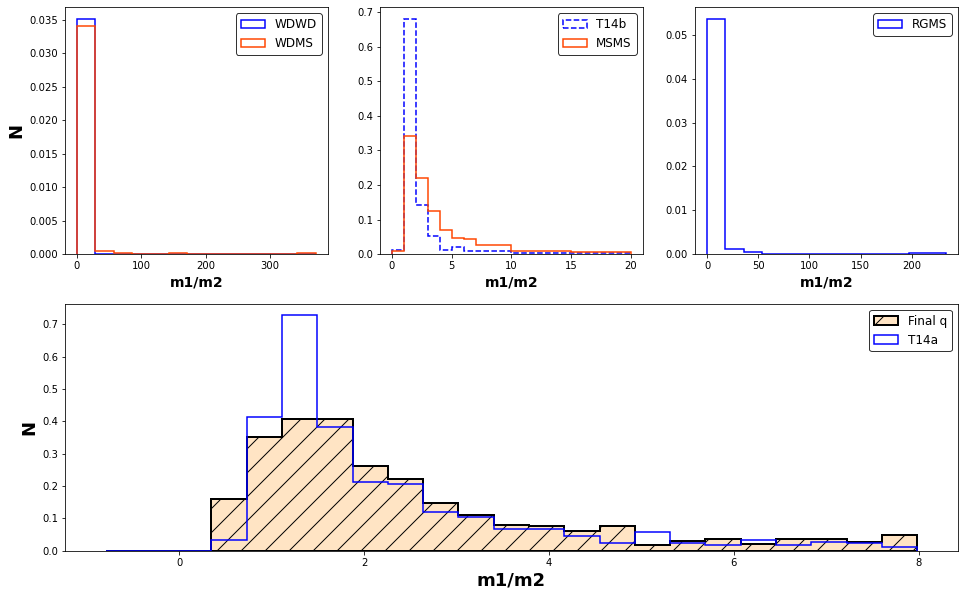

In [2498]:
plt.figure(figsize=(16, 10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)

t14a_bin_trip = t14a[(t14a['Nc'] == '2') | (t14a['Nc'] == '3')]
t14a_bin_trip = t14a_bin_trip[(t14a_bin_trip['Period'] != 0) & (t14a_bin_trip['M1'] != 0) & (t14a_bin_trip['M2'] != 0) ]

minWD,maxWD = np.min( WDMS['m1']/WDMS['m2'] ), np.max( WDMS['m1']/WDMS['m2']  )
minRG,maxRG = np.min( RGMS['m1']/RGMS['m2']  ), np.max( RGMS['m1']/RGMS['m2']  )
mint14a,maxt14a = 0, np.max( t14b_inner['M1'] / t14b_inner['M2']  )

binsWD = np.linspace(0,maxWD,14)
binsRG = np.linspace(0,maxRG,14)
binst14a = np.linspace(mint14a,maxt14a,14)
final_periods = np.log10(df_final['P_in'])
bins2 = np.linspace(np.min(final_periods),np.max(final_periods),24)

#ax1.hist(WD_['m1']/WD_['m2'],bins=binsWD,density=True,label='WD_',histtype='step', linewidth=1.5,color='gray',linestyle='--')
ax1.hist(WDWD['m1']/WDWD['m2'],bins=binsWD,density=True,label='WDWD',histtype='step', linewidth=1.5,color='b')
ax1.hist(WDMS['m1']/WDMS['m2'],bins=binsWD,density=True,label='WDMS',histtype='step', linewidth=1.5,color='orangered',cumulative=False)

#ax3.hist(RG_['m1']/RG_['m2'],bins=binsRG,density=True,label='RG_',histtype='step', linewidth=1.5,color='gray',linestyle='--')
ax3.hist(RGMS['m1']/RGMS['m2'],bins=binsRG,density=True,label='RGMS',histtype='step', linewidth=1.5,color='b')

ya = t14a_bin_trip['M1'].astype(float) / t14a_bin_trip['M2'].astype(float)
yb = t14b_inner['M1'] / t14b_inner['M2']

binst14a = [0,1,2,3,4,5,6,7,10,15,20]
ax2.hist(yb,histtype='step',linewidth=1.5,bins=binst14a, density=True,label='T14b',color='b',cumulative=False,linestyle='--')
ax2.hist(MSMS['m1']/MSMS['m2'],bins=binst14a,density=True,label='MSMS',histtype='step', linewidth=1.5,color='orangered',cumulative=False)

ax4.hist(df_final['m1']/df_final['m2'],bins=bins2,density=True,label='Final q', linewidth=2.0,
         facecolor='bisque',edgecolor='black', hatch='/',histtype='stepfilled')
ax4.hist(ya,histtype='step',linewidth=1.5,bins=bins2, density=True,label='T14a',color='b',cumulative=False)

ax4.set_xlabel('m1/m2',fontsize=18,fontweight='bold')
ax1.set_ylabel('N',fontsize=18,fontweight='bold')
ax4.set_ylabel('N',fontsize=18,fontweight='bold')

ax1.set_xlabel('m1/m2',fontsize=14,fontweight='bold')
ax2.set_xlabel('m1/m2',fontsize=14,fontweight='bold')
ax3.set_xlabel('m1/m2',fontsize=14,fontweight='bold')


ax1.legend(edgecolor="black", prop={'size': 12})
ax2.legend(edgecolor="black", prop={'size': 12})
ax3.legend(edgecolor="black", prop={'size': 12})
ax4.legend(edgecolor="black", prop={'size': 12})

plt.savefig('/Users/bijan1339/Desktop/Research/Figures/mass_ratios.pdf')
plt.show()

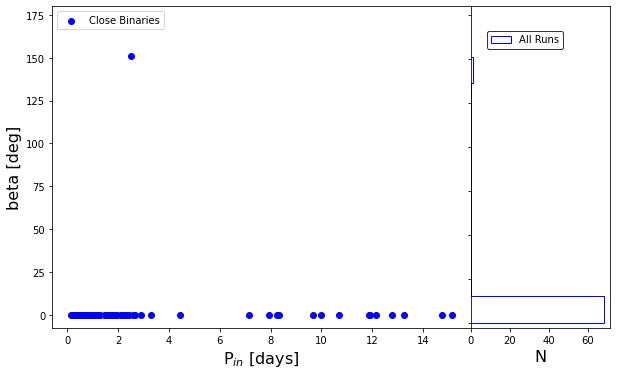

In [2499]:
#F&T (2007) Figure 10
#x1 = close_df_initial['P_in']#i_init_close
#y1 = close_df_initial['beta']#i_final_close
from matplotlib.pyplot import GridSpec
x2 = close_df_final['P_in']#i_init_close
y2 = close_df_final['beta']#i_final_close

fig = plt.figure(figsize=(10,8))

gs = GridSpec(4,4)

ax = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

c1,c2 = 'navy','b'#colors
#ax.scatter(x1,y1,label='Close Binaries',c=c1)
ax.scatter(x2,y2,label='Close Binaries',c=c2)
ax.set_ylim(top=180.)
ax_marg_y.set_ylim(-3,180.)

ax_marg_y.hist([y2],orientation="horizontal",histtype='step',color=[c2],density=False
               ,label=['All Runs','Close Binaries'])
ax_marg_y.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")
# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax.set_xlabel('P$_{in}$ [days]',fontsize=16)
ax.set_ylabel('beta [deg]',fontsize=16)

# Set labels on marginals
ax_marg_y.set_xlabel('N',fontsize=16)
ax.legend(loc=2)
fig.subplots_adjust(wspace=0)
plt.show()
#fig.savefig('/Users/bijan1339/Desktop/Research/Figures/Figure5.pdf')

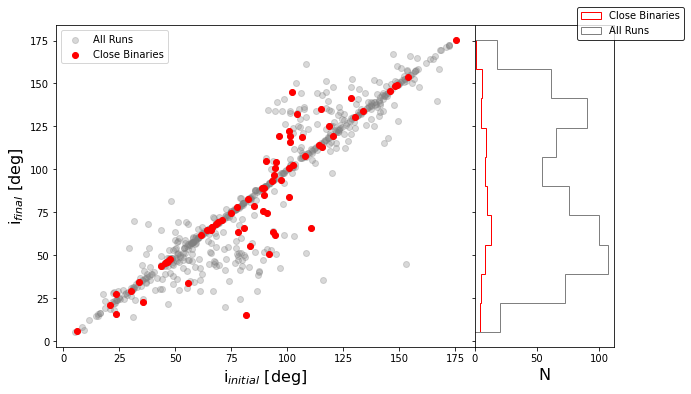

In [2500]:
from matplotlib.gridspec import GridSpec

x1 = df_initial['i']#i_init_all
y1 = df_final['i']#i_final_all

x2 = close_df_initial['i']#i_init_close
y2 = close_df_final['i']#i_final_close

fig = plt.figure(figsize=(10,8))

gs = GridSpec(4,4)

ax = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

c1,c2 = 'gray','red'#colors
ax.scatter(x1,y1,label='All Runs',c=c1,alpha=0.3)
ax.scatter(x2,y2,label='Close Binaries',c=c2)
ax_marg_y.hist([y1,y2],orientation="horizontal",histtype='step',color=[c1,c2],density=False
               ,label=['All Runs','Close Binaries'])
ax_marg_y.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")
# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax.set_xlabel('i$_{initial}$ [deg]',fontsize=16)
ax.set_ylabel('i$_{final}$ [deg]',fontsize=16)

# Set labels on marginals
ax_marg_y.set_xlabel('N',fontsize=16)
ax.legend(loc=2)
fig.subplots_adjust(wspace=0)
plt.show()
fig.savefig('/Users/bijan1339/Desktop/Research/Figures/Figure5.pdf')

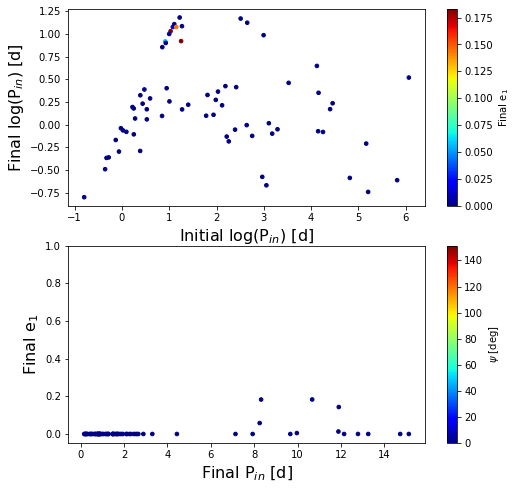

In [2501]:
#PLOTTING FIGURE 3 (CLOSE BINARIES)
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
close_periods_ini = np.sqrt(close_df_initial['a1']**3 / (close_df_initial['m1']+close_df_initial['m2']) )*365.25
close_periods_final = np.sqrt(close_df_final['a1']**3 / (close_df_final['m1']+close_df_final['m2']) )*365.25

periods_init_close, periods_final_close = np.log10(close_periods_ini),np.log10(close_periods_final)
cmap = 'jet'
scatter1 = ax1.scatter(np.log10(close_df_initial['P_in']),np.log10(close_df_final['P_in']),c=close_df_final['e1'],cmap=cmap,s=13)
ax1.set_xlabel('Initial log(P$_{in}$) [d]', fontsize = 16)
ax1.set_ylabel('Final log(P$_{in}$) [d]', fontsize = 16)
fig.colorbar(scatter1, ax=ax1, label="Final e$_1$")

#scatter2 = ax2.scatter(10**periods_final_close,e1_final_close,c=beta_close,cmap = cmap,s=13)
scatter2 = ax2.scatter(close_df_final['P_in'], close_df_final['e1'], c=close_df_final['beta'], cmap = cmap, s=13)
ax2.set_ylim(-0.05,1.)

ax2.set_xlabel('Final P$_{in}$ [d]', fontsize = 16)
ax2.set_ylabel('Final e$_1$', fontsize = 16)
fig.colorbar(scatter2,ax=ax2, label="$\psi$ [deg]")

plt.show()
#fig.savefig('/Users/bijan1339/Desktop/Research/Figures/close_binaries.pdf')


# Outer Binary Analyses

Text(0.5, 1.0, 'Outer Period Distribtution')

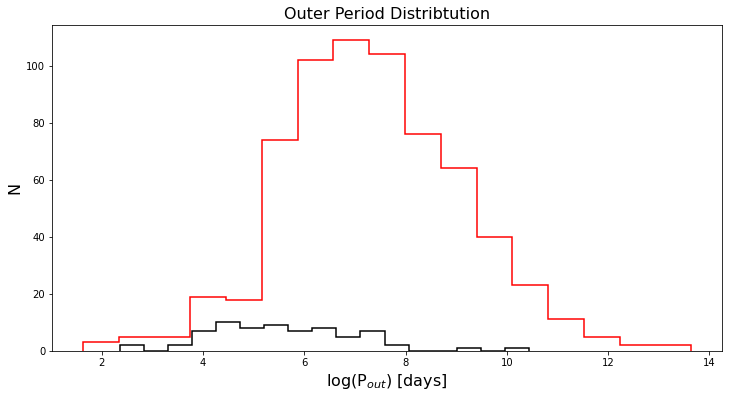

In [2503]:
x1 = np.sqrt(close_df_final['a2']**3 / (close_df_final['m1']+close_df_final['m2']+close_df_final['m3']) )*365.25
x2 = np.sqrt(df_final['a2']**3 / (df_final['m1']+df_final['m2']+df_final['m3']) )*365.25

_, bins1 = np.histogram(np.log10(x1 + 1), bins=17)
_, bins2 = np.histogram(np.log10(x2 + 1), bins=17)

plt.hist(np.log10(x1), bins=17,density=False,histtype='step', linewidth=1.5,color='black')
plt.hist(np.log10(x2), bins=bins2,density=False,histtype='step', linewidth=1.5,color='red')

plt.xlabel('log(P$_{out}$) [days]',fontsize=16)
plt.ylabel('N',fontsize=16)
plt.title('Outer Period Distribtution',fontsize=16)

In [1957]:
labels_y1 = [item for item in ax_marg_y1.get_xticks()]
labels_y1


[0.0, 250.0, 500.0]

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/3202545874.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y1.set_xticklabels(labels_y1)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/3202545874.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_marg_y2.set_xticklabels(labels_y2)


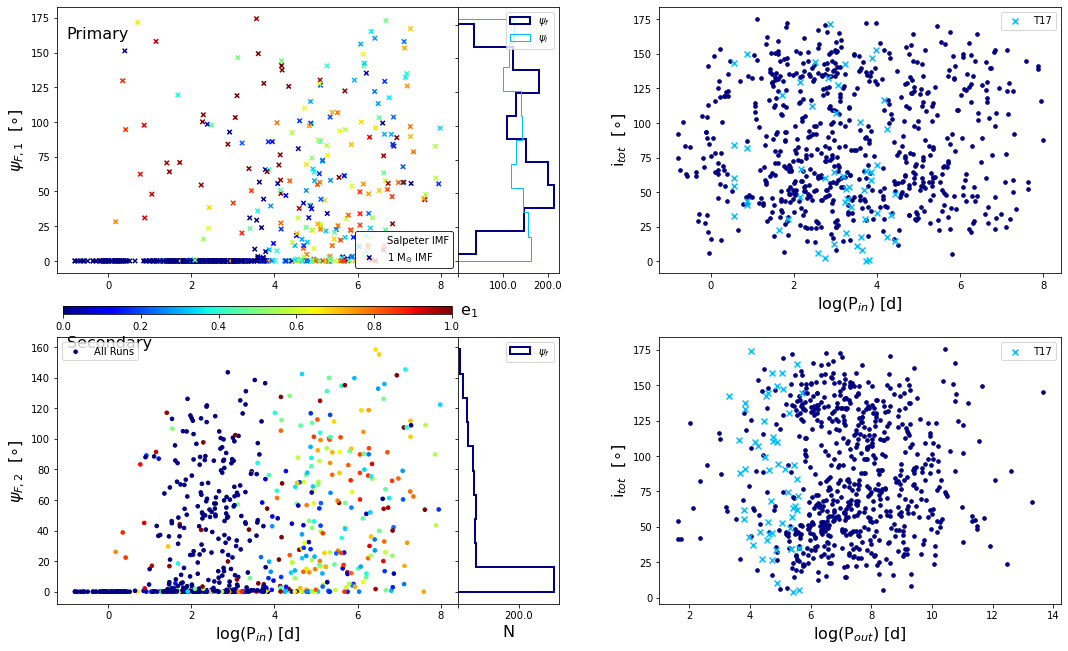

In [2504]:
from matplotlib.gridspec import GridSpec

x11 = np.log10(df_final_salpeter['P_in'])
y11 = df_final_salpeter['beta']
x12 = np.log10(df_final_1m['P_in'])
y12 = df_final_1m['beta']

x2 = np.log10(df_final['P_in'])
y2 = df_final['beta2']


fig = plt.figure(figsize=(18,12))

gs = GridSpec(12,10)

ax = fig.add_subplot(gs[1:6,0:4])
ax2 = fig.add_subplot(gs[7:12,0:4])
ax3 = fig.add_subplot(gs[1:6,6:10])
ax4 = fig.add_subplot(gs[7:12,6:10])

ax_marg_y1 = fig.add_subplot(gs[1:6,4])
ax_marg_y2 = fig.add_subplot(gs[7:12,4])

#color_ax = fig.add_subplot(gs[6,0:3])

cmap = 'jet'
scatter1 = ax.scatter(x11,y11,c=df_final_salpeter['e1'],cmap=cmap,s=20,marker='.',label='Salpeter IMF')
ax.scatter(x12,y12,c=df_final_1m['e1'],cmap=cmap,s=20,marker='x',label='1 M$_{\odot}$ IMF')
ax2.scatter(x2,y2,label='All Runs',c=df_final['e1'],cmap=cmap,s=13)

ax3.scatter(np.log10(df_final['P_in']),df_final['i'],color='navy',s=13)
ax3.scatter(np.log10(t17_inner['P']*365.25),t17_inner['Phi'],color='deepskyblue',s=35,label='T17',marker='x')
ax4.scatter(np.log10(df_final['P_out']),df_final['i'],color='navy',s=13)
ax4.scatter(np.log10(t17_outer['P']*365.25),t17_outer['Phi'],color='deepskyblue',s=35,label='T17',marker='x')


ax_marg_y1.hist(y1,orientation="horizontal",histtype='step',color='navy',density=False ,label='$\psi_{f}$',linewidth=2.)
ax_marg_y1.hist(df_initial['beta'],orientation="horizontal",histtype='step',color='deepskyblue',density=False ,label='$\psi_{i}$')
#ax_marg_y1.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

ax_marg_y2.hist(y2,orientation="horizontal",histtype='step',color='navy',density=False ,label='$\psi_{f}$',linewidth=2.)
#ax_marg_y2.legend(bbox_to_anchor=(0.7, 0.94),edgecolor="black")

# Turn off tick labels on marginals
plt.setp(ax_marg_y1.get_yticklabels(), visible=False)
plt.setp(ax_marg_y2.get_yticklabels(), visible=False)

# Set labels on joint
#ax.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax.set_ylabel('$\psi_{F,1}$  [$\circ$]',fontsize=16)
ax2.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax2.set_ylabel('$\psi_{F,2}$  [$\circ$]',fontsize=16)
ax3.set_xlabel('log(P$_{in}$) [d]',fontsize=16)
ax3.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)
ax4.set_xlabel('log(P$_{out}$) [d]',fontsize=16)
ax4.set_ylabel('i$_{tot}$  [$\circ$]',fontsize=16)

ax.text(-1.,160,'Primary',fontsize=16)
ax2.text(-1.,160,'Secondary',fontsize=16)

# Set labels on marginals
ax_marg_y2.set_xlabel('N',fontsize=16)
ax_marg_y1.legend(),ax_marg_y2.legend()

labels_y1 = [item for item in ax_marg_y1.get_xticks()]
labels_y2 = [item for item in ax_marg_y2.get_xticks()]
labels_y1[0] = ''
labels_y2[0] = ''

ax_marg_y1.set_xticklabels(labels_y1)
ax_marg_y2.set_xticklabels(labels_y2)

ax.legend(loc=4,edgecolor='k'),ax2.legend(),ax3.legend(),ax4.legend()
fig.subplots_adjust(wspace=0)

#COLORBAR SETTINGS
cbar_ax = fig.add_axes([0.13, 0.46, 0.30, 0.01]) #[left, bottom, width, height]
cb = fig.colorbar(scatter1, cax=cbar_ax, orientation="horizontal",ticks=[0, 0.2, 0.4, 0.6,0.8,1.])
scatter1.set_clim([0, 1])
cb.ax.text(1.02,0,'e$_1$', fontsize=16,fontweight='light')

#fig.savefig('/Users/bijan1339/Desktop/Research/Figures/period_psi.pdf')
plt.show()

/Users/bijan1339/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


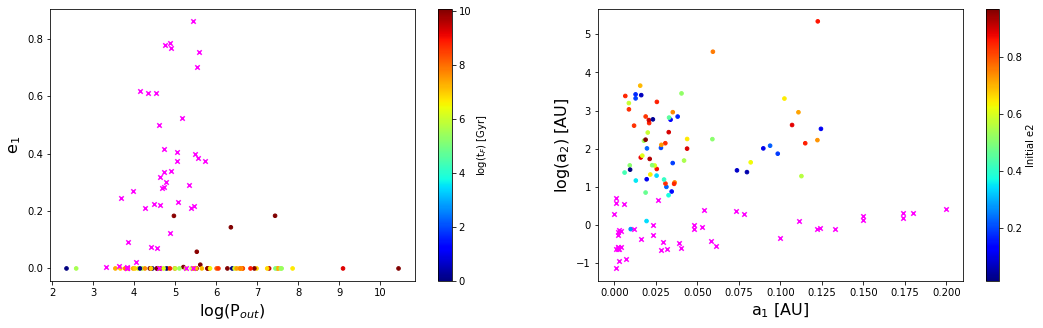

In [2505]:
#OUTER ORBIT CONFIGURATION
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
cmap = 'jet'
#x = np.linspace(0.025,0.21)
these_inner = t17_inner[t17_inner['a'] <=0.2]
these_outer = t17_outer[t17_outer['WDS'].isin(these_inner['WDS'])]

scatter1 = ax1.scatter(np.log10(close_df_final['P_out']),close_df_final['e1'],
                       c=np.log10(close_df_final['t']).replace(-np.inf, 0),cmap=cmap,s=13)
ax1.scatter(np.log10(these_outer['P']*365.25),these_inner['e'],color='magenta',s=20,alpha=1.,label='T17',marker='x')

#ax1.scatter(np.log10(t17_outer['P']*365.25),t17_outer['e'],color='deepskyblue',s=13,label='T17')

ax1.set_xlabel('log(P$_{out}$)',fontsize=16)
ax1.set_ylabel('e$_1$',fontsize=16)
fig.colorbar(scatter1,ax=ax1, label="log(t$_F$) [Gyr]")
#ax1.set_ylim(top=1.)

scatter2 = ax2.scatter(close_df_final['a1'],np.log10(close_df_final['a2']),c=close_df_initial['e2'],cmap=cmap,s=13)
ax2.scatter(these_inner['a'],np.log10(these_outer['a']),color='magenta',s=20,alpha=1.,label='T17',marker='x')
ax2.set_xlabel('a$_1$ [AU]',fontsize=16)
ax2.set_ylabel('log(a$_2$) [AU]',fontsize=16)
fig.colorbar(scatter2,ax=ax2, label="Initial e2")
#ax2.text(-0.5,150,'Secondary',fontsize=14)
#ax2.plot(x,np.log10(35900*x/91-711/91))

#fig.savefig('/Users/bijan1339/Desktop/Research/Figures/period_psi.pdf')


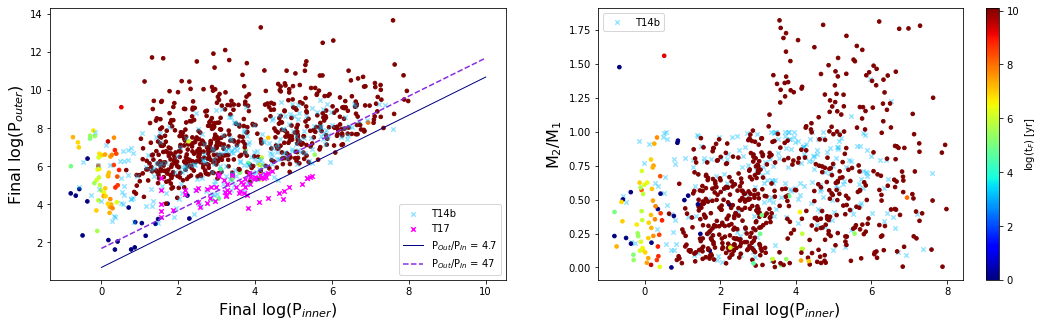

In [2506]:
#OUTER ORBIT CONFIGURATION
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
cmap = 'jet'
x = np.linspace(0,10,1000)
y = np.log10(4.7) +x
yy = np.log10(47) +x

x1,y1 = np.log10(df_final['P_in']), np.log10(df_final['P_out'])
x2,y2 = np.log10(df_final['P_in']), df_final['m2']/df_final['m1']

scatter1 = ax1.scatter(x1, y1,
                       c=np.log10(df_final['t']).replace(-np.inf, 0),cmap=cmap,s=13)
ax1.scatter(t14b_inner['logP'], t14b_outer['logP'],color='deepskyblue',s=20,alpha=0.4,label='T14b',marker='x')
y17,y217 = np.log10(t17[t17['P_out']!=0.]['P1']*365.25),np.log10(t17[t17['P_out']!=0.]['P_out']*365.25)
ax1.scatter(y17, y217,color='magenta',s=20,alpha=1.,label='T17',marker='x')


ax1.set_xlabel('Final log(P$_{inner}$)',fontsize=16), ax1.set_ylabel('Final log(P$_{outer}$)',fontsize=16)

# ax2.scatter(np.log10(t14a['Period']), t14a['M2'].astype(float)/t14a['M1'].astype(float),
#             color='gray', alpha=0.3, s=15,label='T14a')
ax2.scatter(t14b_inner['logP'], t14b_inner['M2']/t14b_inner['M1'],
            color='deepskyblue',s=20,alpha=0.4,label='T14b',marker='x')
scatter2 = ax2.scatter(x2, y2,
                       c=np.log10(df_final['t']).replace(-np.inf, 0),cmap=cmap,s=13)
ax2.set_xlabel('Final log(P$_{inner}$)',fontsize=16), ax2.set_ylabel('M$_2$/M$_1$',fontsize=16)
fig.colorbar(scatter2,ax=ax2, label="log(t$_F$) [yr]")
ax1.plot(x,y,color='navy',linewidth=1.,label = 'P$_{Out}$/P$_{In}$ = 4.7')
ax1.plot(x,yy,'--',color='blueviolet',label = 'P$_{Out}$/P$_{In}$ = 47')

ax1.legend(loc=4), ax2.legend()

#plt.savefig('/Users/bijan1339/Desktop/Research/Figures/Period_Ratios.pdf')
plt.show()


In [2512]:
close_df_final#['spintot']/close_df_final['P_in']
def get_spin_periods(row):
    spin1P_radyr = np.sqrt(close_df_final['spin1h']**2.+close_df_final['spin1e']**2.+close_df_final['spin1q']**2.)
    spin2P_radyr = np.sqrt(close_df_final['spin2h']**2.+close_df_final['spin2e']**2.+close_df_final['spin2q']**2.)
    spin1P = 2.*np.pi*365.25/spin1P_radyr
    spin2P = 2.*np.pi*365.25/spin2P_radyr
    return [spin1P,spin2P]


3        8.909771
10       2.254793
15      11.934926
27       0.831122
51       2.657468
          ...    
1176     1.478019
1199     1.634851
1206     0.513987
1213     0.882116
1222     0.752783
Length: 69, dtype: float64

# Comparing to Observations

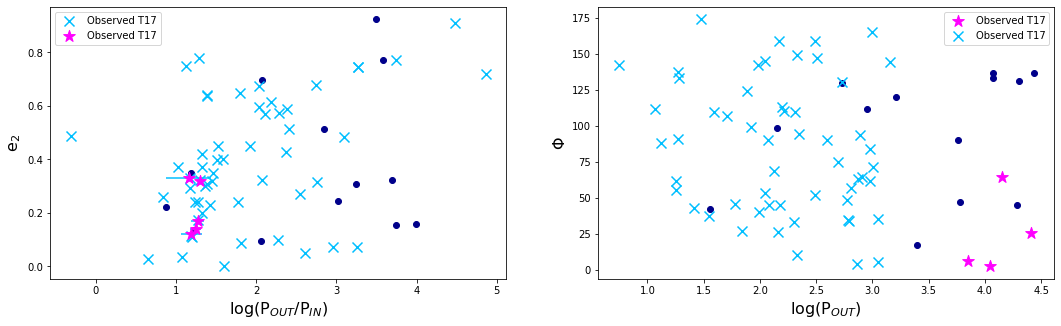

In [2270]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

these = df_final[df_final['P_out'] <= 80*365.25]
y17,y217 = np.log10(t17_outer['P'].reset_index(drop=True)/t17_inner['P'].reset_index(drop=True)),t17_outer['e']

ax1.scatter(np.log10(these['P_out']/these['P_in']),these['e2'],color='darkblue' )
ax2.scatter(np.log10(these['P_out']),these['i'],color='darkblue' )

#Observations
ax1.scatter(y17,y217,color='deepskyblue',marker='x',label='Observed T17',s=100)
ax1.errorbar(np.log10(t17_4obs['Po/Pi']), t17_4obs['eout'], xerr=t17_4obs['e_Po/Pi'],fmt="+",color='deepskyblue')
ax1.scatter(np.log10(t17_4obs['Po/Pi']),t17_4obs['eout'],color='magenta',marker='*',label='Observed T17',s=150,zorder=3)
ax2.scatter(np.log10(t17_4obs['Pout']*365.25),t17_4obs['Phi'],color='magenta',marker='*',label='Observed T17',s=150)
ax2.scatter(np.log10(t17_outer['P']),t17_outer['Phi'],color='deepskyblue',marker='x',label='Observed T17',s=100)

#ax1.set_xlim(-5,100)
ax1.set_xlabel('log(P$_{OUT}$/P$_{IN}$)',fontsize=16)
ax1.set_ylabel('e$_2$',fontsize=16)

#ax2.set_xlim()
ax2.set_xlabel('log(P$_{OUT}$)',fontsize=16)
ax2.set_ylabel('$\Phi$',fontsize=16)

ax1.legend(),ax2.legend()
plt.show()

In [1737]:
#Tokovinin Observations
t14a = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2014a.tsv",delimiter='\t').drop(t14a.index[[0,1]]).reset_index(drop=True)
t14b = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2014b.tsv",delimiter='\t')
t17 = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017.tsv",delimiter='\t')
t17_4obs = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017_4obs.tsv",delimiter='\t')
t17_phi = pd.read_csv("/Users/bijan1339/Desktop/Research/Observations/Tokovinin2017_PHI.tsv",delimiter='\t')

t17_inner = t17_phi[t17_phi['I/O'] == 'I']
t17_outer = t17_phi[t17_phi['I/O'] == 'O']

t14b['logP'] = t14b['logP'].replace('     ',None).astype(float)
t14b['M2'] = t14b['M2'].replace('     ',None).astype(float)
t17_4obs['Phi'] = t17_4obs['Phi'].replace('    ',None).astype(float)

#convert all period column to same units in "Period" columns
def all_to_day(row):
    '''returns period in DAYS from df row'''
    if row['x_Per'] == 'y': return row['Per'] * 365.25 #yr to days
    if row['x_Per'] == 'k': return row['Per'] * 1000. * 365.25 #kyr to days
    if row['x_Per'] == 'd': return row['Per'] #alr days
def add_out_params(row,df=t17_outer):
    ID = row['WDS']
    this_outer_row = df[df['WDS'] == ID]
    P_out, e_out, a_out = this_outer_row['P'],this_outer_row['e'],this_outer_row['a']
    try: 
        return (P_out.iloc[0], e_out.iloc[0], a_out.iloc[0]) 
    except IndexError: 
        return [0.0,0.0,0.0]

t14a['Per'] = t14a['Per'].str.strip().astype(float) #convert to float
t14a['Period'] = t14a.apply(lambda row: all_to_day(row), axis=1)

t17['P_out'] = t17.apply(lambda row: add_out_params(row)[0], axis=1)
t17['e_out'] = t17.apply(lambda row: add_out_params(row)[1], axis=1)
t17['a_out'] = t17.apply(lambda row: add_out_params(row)[2], axis=1)


In [2133]:
t14b_inner.drop_duplicates('HIP0')
ids=t14b_outer['HIP0']
#t14b_outer = t14b_outer.drop_duplicates(subset=['HIP0'], keep=False)

t14b_outer[ids.isin(ids[ids.duplicated()])].sort_values("HIP0")
len(t14b_inner),len(t14b_outer)

(309, 309)

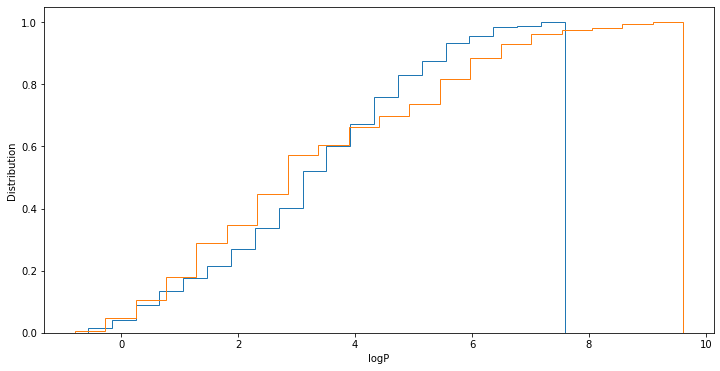

In [2271]:
#drops systems that have both L11 and 12 level (quintiple++)
t14b_inner = t14b[(t14b['L'] == 11) | (t14b['L'] == 12)].drop_duplicates(subset=['HIP0'], keep=False)
t14b_outer = t14b[(t14b['HIP0'].isin(t14b_inner['HIP0']) ) & (t14b['L'] == 1)]

y = t14b_inner['logP']
plt.hist(y, histtype='step',bins=20,cumulative = True,density=True)
plt.hist(np.log10(df_final['P_in']), histtype='step',bins=20,cumulative = True,density=True)
plt.xlabel('logP')
plt.ylabel('Distribution')

plt.show()


In [ ]:
df_final

(<matplotlib.legend.Legend at 0x7f9bff4c6a30>,
 <matplotlib.legend.Legend at 0x7f9bff4d3a60>)

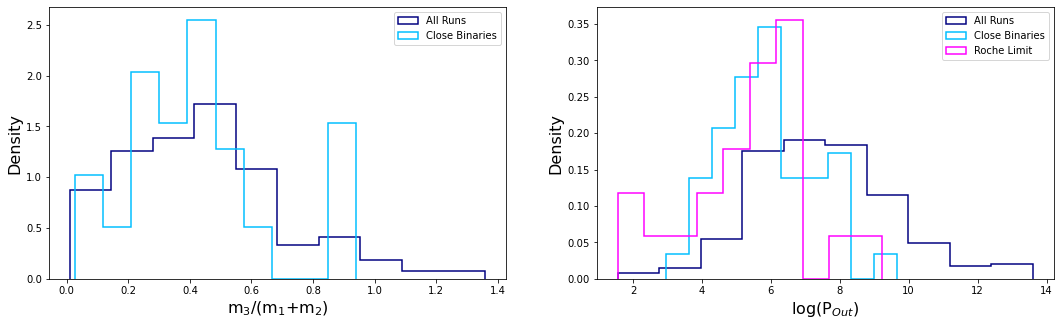

In [2272]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

x = np.linspace(0.025,0.21)
kwargs_hist = {'histtype' :'step','linewidth':1.5,'density':True}

ax1.hist(df_final['m3']/(df_final['m1']+df_final['m2']),**kwargs_hist,color='navy',label='All Runs')
ax1.hist(close_df_final['m3']/(close_df_final['m1']+close_df_final['m2']),**kwargs_hist,color='deepskyblue',label='Close Binaries')

ax1.set_xlabel('m$_3$/(m$_1$+m$_2$)',fontsize=16)
ax1.set_ylabel('Density',fontsize=16)

ax2.hist(np.log10(df_final['P_out']), color='navy',**kwargs_hist,label='All Runs')
ax2.hist(np.log10(close_df_final['P_out']),color='deepskyblue', **kwargs_hist,label='Close Binaries')
ax2.hist(np.log10(merged_df_final['P_out']),color='magenta', **kwargs_hist,label='Roche Limit')


ax2.set_xlabel('log(P$_{Out}$)',fontsize=16)
ax2.set_ylabel('Density',fontsize=16)

ax1.legend(), ax2.legend()

In [634]:
%%time
full_outputs_directory = '/Users/bijan1339/Desktop/Research/Outputs/'
tdis_all=[]
tdis2,tdis3,tdis4,tdis5,tdis6=[],[],[],[],[]
tMS=[]
tWD=[]
tRG = []
tdis_df = pd.DataFrame(columns=df_columns)
looking_for=['[2]','[3]','[4]','[5]','[6]']


for filename in os.listdir(full_outputs_directory):

    n = maybe_float(filename.split('_')[-1].split('.')[0] )
    full_path = full_outputs_directory + filename
    #this_file = open(full_path)
    #matching_lines = [line for line in this_file.readlines() if ('tdis' in line) or ('WD' in line)]
    
    MS_count = 0
    RG_count = 0
    WD_count = 0
    matching_lines=[]
    if  type(n) == float and 1000 < n < 2000:
        with open(full_path) as this_file:
            for line in this_file:
                this_flag = line.rsplit('\t',1)[-1].strip()
                if 'tdis' in this_flag:
                    matching_lines.append(line)
                if 'MS' in this_flag and MS_count == 0:
                    matching_lines.append(line)
                    MS_count+=1
                if 'RG' in this_flag and RG_count == 0:
                    matching_lines.append(line)
                    RG_count+=1
                if 'WD' in this_flag and WD_count == 0:
                    matching_lines.append(line)
                    WD_count+=1

    #     for line in this_file:
    #         print(line)
    #         break
    #         if ('tdis' in line) or ('WD' in line):
    #             matching_lines.append(line)
    #     WD_count = 0
    #     for l in this_file.readlines():
    #         #if '2564' in filename: print('y')
    #         if 'WD' in l and WD_count == 0:
    #             print('First WD!')
    #             WD_count+=1
    #             matching_lines.append(l) #get first instance of WD printout

        for line in matching_lines:
            line = [x.strip() for x in line.split('\t')]
            this_t = float(line[2])
            tdis_all.append(this_t)


            if '[2]' in line[-1]: tdis2.append(this_t)
            if '[3]' in line[-1]: tdis3.append(this_t)
            if '[4]' in line[-1]: tdis4.append(this_t)
            if '[5]' in line[-1]: tdis5.append(this_t)
            if '[6]' in line[-1]: tdis6.append(this_t)
            if 'MS' in line[-1]: tMS.append(this_t)
            if 'RG' in line[-1]: tRG.append(this_t)
            if 'WD' in line[-1]: tWD.append(this_t) 
            try:
                tdis_df.loc[len(tdis_df)]=[n]+line
            except ValueError:
                continue
#     this_file.close()
for i in range(1,len(tdis_df.columns)-1):tdis_df.iloc[:, i] = tdis_df.iloc[:, i].astype(float)  

CPU times: user 33 s, sys: 4.56 s, total: 37.5 s
Wall time: 39.6 s


/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:28: RuntimeWarning: invalid value encountered in log10
  n_all, b_all,p_all = ax9.hist(np.log10(tdis_all),histtype='step',linewidth=1.5,color='b',bins=bins)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.8,'tMS1',fontsize=16, color = 'r')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:31: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.7,'tMS2',fontsize=16, color = 'g')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:32: RuntimeWarning: invalid value encountered in log10
  ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.6,'tMS3',fontsize=16, color = 'b')
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_1048/538222405.py:40: RuntimeWarning: invalid value encountered in l

Text(0.5, 0.98, 'Discontinuity Times')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


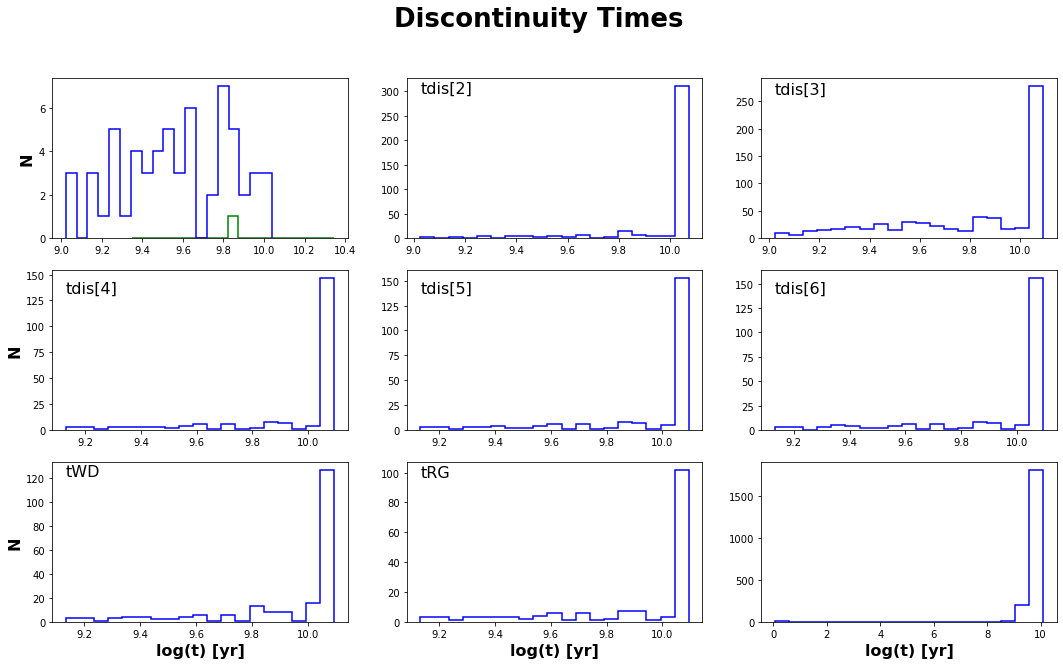

In [631]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))

tMS1 = tdis_df[tdis_df['flag'].str.contains('MS1')]['t'].astype(float)
tMS2 = tdis_df[tdis_df['flag'].str.contains('MS2')]['t'].astype(float)
tMS3 = tdis_df[tdis_df['flag'].str.contains('MS3')]['t'].astype(float)
tRG = tdis_df[tdis_df['flag'].str.contains('RG')]['t'].astype(float)
tWD = tdis_df[tdis_df['flag'].str.contains('WD')]['t'].astype(float)
tdis2 = tdis_df[tdis_df['flag'].str.contains('[2]')]['t'].astype(float)
tdis3 = tdis_df[tdis_df['flag'].str.contains('[3]')]['t'].astype(float)
tdis4 = tdis_df[tdis_df['flag'].str.contains('[4]')]['t'].astype(float)
tdis5 = tdis_df[tdis_df['flag'].str.contains('[5]')]['t'].astype(float)
tdis6 = tdis_df[tdis_df['flag'].str.contains('[6]')]['t'].astype(float)

#bins = np.linspace(0,np.max(np.log10(tdis6)),14)
bins=19
#n1, b1,p1 = ax1.hist(np.log10(tMS1),histtype='step',linewidth=1.5,color='r',bins=bins)
ax1.hist(np.log10(tMS2),histtype='step',linewidth=1.5,color='g',bins=bins)
ax1.hist(np.log10(tMS3),histtype='step',linewidth=1.5,color='b',bins=bins)

#n1, b1,p1 = ax1.hist(np.log10(tMS),histtype='step',linewidth=1.5,color='b',bins=bins)
n2, b2,p2 = ax2.hist(np.log10(tdis2),histtype='step',linewidth=1.5,color='b',bins=bins)
n3, b3,p3 = ax3.hist(np.log10(tdis3),histtype='step',linewidth=1.5,color='b',bins=bins)
n4, b4,p4 = ax4.hist(np.log10(tdis4),histtype='step',linewidth=1.5,color='b',bins=bins)
n5, b5,p5 = ax5.hist(np.log10(tdis5),histtype='step',linewidth=1.5,color='b',bins=bins)
n6, b6,p6 = ax6.hist(np.log10(tdis6),histtype='step',linewidth=1.5,color='b',bins=bins)
n_wd, b_wd,p_wd = ax7.hist(np.log10(tWD),histtype='step',linewidth=1.5,color='b',bins=bins)
n_rg, b_rg,p_rg = ax8.hist(np.log10(tRG),histtype='step',linewidth=1.5,color='b',bins=bins)
n_all, b_all,p_all = ax9.hist(np.log10(tdis_all),histtype='step',linewidth=1.5,color='b',bins=bins)

ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.8,'tMS1',fontsize=16, color = 'r')
ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.7,'tMS2',fontsize=16, color = 'g')
ax1.text(np.min(np.log10(tMS)),np.max(n1)*0.6,'tMS3',fontsize=16, color = 'b')
ax2.text(np.min(np.log10(tdis2)),np.max(n2)-15,'tdis[2]',fontsize=16)
ax3.text(np.min(np.log10(tdis3)),np.max(n3)-15,'tdis[3]',fontsize=16)
ax4.text(np.min(np.log10(tdis4)),np.max(n4)-15,'tdis[4]',fontsize=16)
ax5.text(np.min(np.log10(tdis5)),np.max(n5)-15,'tdis[5]',fontsize=16)
ax6.text(np.min(np.log10(tdis6)),np.max(n6)-15,'tdis[6]',fontsize=16)
ax7.text(np.min(np.log10(tWD)),np.max(n_wd)-5,'tWD',fontsize=16)
ax8.text(np.min(np.log10(tRG)),np.max(n_rg)-5,'tRG',fontsize=16)
ax9.text(np.min(np.log10(tdis_all)),np.max(n_all)-30,'All tdis',fontsize=16)

ax7.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')
ax8.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')
ax9.set_xlabel('log(t) [yr]',fontsize=16,fontweight='bold')

ax1.set_ylabel('N',fontsize=16,fontweight='bold')
ax4.set_ylabel('N',fontsize=16,fontweight='bold')
ax7.set_ylabel('N',fontsize=16,fontweight='bold')

fig.suptitle('Discontinuity Times',fontsize=26,fontweight='bold')

In [633]:
tdis_df[tdis_df['type1']==5.]

,N,sur,sur2,t,e1,e2,g1,g2,a1,i1,i2,i,spin1h,spintot,beta,vp,spin1e,spin1q,spin2e,spin2q,spin2h,htot,m1,R1,m2,R2,a2,m3,Roche1,R1_pow,type1,type2,type3,beta2,gamma,gamma2,flag
20,1073.0,1.0,2.0,1.245869e+10,0.689649,0.425895,2.323961,1.244506,306.935000,81.16144,7.614039,88.77548,-6.632927e-07,0.000672,90.056590,88.77548,4.532184e-04,-4.955867e-04,0.307307,-11.933840,-25.433720,77.55369,0.724661,0.111260,0.221900,0.001152,40823.2900,0.0921,0.202703,0.068603,5.0,0.0,0.0,154.856100,47.55681,88.52491,RG
60,1477.0,1.0,2.0,1.245868e+10,0.731966,0.141365,-2.341839,-2.144731,30.022780,151.13530,4.184579,155.31990,2.801600e-02,0.042840,49.158280,155.31990,3.322742e-03,3.223833e-02,100.048900,27.950240,74.922670,24.85729,0.724668,0.111142,0.398300,0.001751,287.1648,0.4543,0.214357,0.078673,5.0,0.0,0.0,54.199190,84.11541,15.60854,RG
64,1463.0,1.0,2.0,1.245869e+10,0.003669,0.180963,-1.874312,0.083981,4.999032,67.02503,0.156887,67.18194,7.237124e-03,0.007237,0.002006,67.18194,1.359250e-07,2.137958e-07,0.017916,-0.018882,16.574980,13.37178,0.724661,0.111260,0.181361,0.001002,25148.9500,0.9003,0.199767,0.065084,5.0,0.0,1.0,0.089977,57.55302,46.50364,RG
108,1476.0,1.0,2.0,1.245868e+10,0.172646,0.200982,-1.458133,2.930971,680.672600,83.35599,9.666180,93.02217,1.081888e-04,0.001219,84.908080,93.02217,-7.481157e-04,-9.563070e-04,-6.469388,-24.237220,-6.431062,156.53160,0.724666,0.111171,0.215161,0.001128,5792.3650,0.4046,0.202059,0.068009,5.0,0.0,0.0,104.378800,128.03600,104.94490,RG
116,1270.0,1.0,2.0,1.245869e+10,0.592336,0.833958,2.630469,-0.519577,22.401350,132.62740,2.424995,135.05240,4.992736e-02,0.049940,1.295348,135.05240,6.176055e-04,-9.450409e-04,4.300884,15.621690,7.240248,22.86713,0.724661,0.111260,0.186200,0.001021,2505.6210,0.4340,0.200122,0.065542,5.0,0.0,0.0,65.922610,56.83448,74.60698,RG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,1490.0,1.0,2.0,1.245868e+10,0.829290,0.384143,-1.313684,-0.982968,134.452700,126.81760,3.703034,130.52070,4.783234e-04,0.000673,44.734510,130.52070,3.535649e-04,3.155686e-04,6.241844,9.949943,26.685400,39.67704,0.724668,0.111143,0.225079,0.001163,735.8707,0.7331,0.202715,0.068779,5.0,0.0,1.0,23.756960,41.74999,57.89894,RG
1939,1136.0,1.0,2.0,1.245869e+10,0.779389,0.554950,-1.009218,-0.879293,33.336870,55.54133,2.549336,58.09067,2.824908e-02,0.031168,24.995150,58.09067,4.710374e-04,1.316143e-02,-265.422600,252.522100,-88.475990,26.54357,0.724661,0.111260,0.639092,0.002871,1730.7970,0.7891,0.228941,0.086420,5.0,0.0,1.0,103.577100,87.95030,136.42680,RG
1946,1485.0,1.0,2.0,1.246000e+10,0.209591,0.644463,1.727362,-0.126706,12.680140,64.07451,0.834909,64.90942,7.706917e-02,0.077069,0.137338,64.90942,1.347812e-04,1.263367e-04,-95.501960,-1739.709000,234529.800000,24.41921,0.722919,0.141839,0.522998,0.000065,33193.6800,0.5507,0.283430,0.106202,5.0,11.0,11.0,0.425644,43.14771,93.14212,RG
1955,1297.0,1.0,2.0,1.245869e+10,0.591539,0.361847,-2.953459,-1.526041,76.237570,92.93408,3.430115,96.36420,-9.719061e-02,0.101723,162.832000,96.36420,-1.654788e-02,2.505464e-02,273.519100,-74.580110,196.011700,51.17038,0.724661,0.111260,0.613600,0.002739,5255.8400,0.6933,0.227505,0.085794,5.0,0.0,0.0,55.340490,123.44360,15.25200,RG


In [ ]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1_pow','type1','type2','type3','beta2','gamma','gamma2','flag']

In [308]:
m1i = 20.
m2i = 1.100000e-01
m3i = 1.100000e-01 
a2i = 9.440055e+03
a1i = 6.739369e+01

m1f = 1.999712e+01
m2f = 1.100000e-01
m3f = 1.100000e-01
a2f = 9.441399e+03
a1f = 6.740333e+01
  
    
#m1=2.000000e+01 m2=1.100000e-01 m3=1.100000e-01 e2=3.000000e-01 a2=9.440055e+03 a1=6.739369e+01 e1=3.171351e-01

# 1 	 2 	 93750.000000 	3.171351e-01 	 3.000000e-01 	 -5.357101e-01 	 -2.380343e+00 	 6.740333e+01 	  
# 9.227084e-01 	  7.729163e-02   	  1.000000e+00 	  1.424999e+03 	  1.581055e+03 	  2.567099e+01 	  
# 1.000000e+00 	  4.843325e+02   	  4.842870e+02 	  -2.600881e-11 	  4.381441e-11 	  4.779300e+00 	  
# 2.193704e+02 	  1.999712e+01 	  2.804880e-02  	  1.100000e-01 	 6.661498e-04 	 9.441399e+03 	 
# 1.100000e-01 	 4.683357e-02 	 4.942294e-03 	 1.000000 	 0.000000 	 0.000000 	 0.000000e+00 	 
# 4.499731e+01 	 1.800000e+02 	 P

In [311]:
m1i = 1.100000e-01
m2i = 1.100000e-01
m3i = 2.000000e+01
a2i = 9.000000e+03
a1i = 1.000000e+02


m1f = 1.100000e-01
m2f = 1.100000e-01
m3f = 2.269600e+00
a2f = 8.597125e+04
a1f = 1.000000e+02

#works for m1 and m2
#works for m1 only
#works for m3 only (inner not outer)

# 2        2       0.000000       6.993716e-01     9.818988e-01    1.969973e+00    3.445281e+00    
# 1.000000e+02     9.896218e-02    1.037825e-03            1.000000e-01    -3.736757e+00           
# 0.000000e+00    1.414315e+02    0.000000e+00    2.106936e+00            2.106936e+00    0.000000e+00    
# 0.000000e+00    4.779300e+00    2.106446e+01    1.100000e-01    6.661498e-04            1.100000e-01   
# 6.661498e-04    9.000000e+03    2.000000e+01    0.000000e+00    5.287235e-04    0.000000        0.000000        
# 1.000000        0.000000e+00    4.500000e+01    4.500000e+01    FIRST

# 1        3       125000102.409432       6.993716e-01     9.818988e-01    1.970021e+00    -2.837903e+00   
# 1.000000e+02     9.896211e-02    1.037825e-03            1.000000e-01    -3.736757e+00           4.779300e+00    
# 1.414315e+02    0.000000e+00    2.107035e+00            2.106836e+00    -3.627023e-08           1.530165e-08    
# 4.779300e+00    2.106446e+01    1.100000e-01    6.661562e-04            1.100000e-01   6.661562e-04    
# 8.597125e+04    2.269600e+00    1.398840e-03    5.287285e-04    0.000000        0.000000        13.000000       
# 0.000000e+00    4.499730e+01    1.800000e+02    END

In [312]:
(m1i+m2i)/(m1f+m2f) - (a1f/a1i)

0.0

In [314]:
((m1i+m2i+m3i)/(m1f+m2f+m3f)), ( (a2f/a2i))

(8.121786632390744, 9.55236111111111)

In [1107]:
1/0.16421241690189078

6.089673478208734

In [1195]:
RG1_cond1 = ((tdis_df['type1'] == 5.) | (tdis_df['type1'] == 6.)) & (tdis_df['flag'].str.contains('tdis1')) 
RG1_cond2 = ((tdis_df['type2'] == 5.) | (tdis_df['type2'] == 6.)) & (tdis_df['flag'].str.contains('tdis2')) 
RG1_cond3 = ((tdis_df['type3'] == 5.) | (tdis_df['type2'] == 6.)) & (tdis_df['flag'].str.contains('tdis3')) 

WD_cond1 = ((tdis_df['type1'] == 11.) | (tdis_df['type1'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 
WD_cond2 = ((tdis_df['type2'] == 11.) | (tdis_df['type2'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 
WD_cond3 = ((tdis_df['type3'] == 11.) | (tdis_df['type2'] == 12.)) & (tdis_df['flag'].str.contains('WD')) 

typeis2_cond1 = (tdis_df['type1'] == 2.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis2_cond2 = (tdis_df['type2'] == 2.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis2_cond3 = (tdis_df['type3'] == 2.)  & (tdis_df['flag'].str.contains('tdis3'))

typeis3_cond1 = (tdis_df['type1'] == 3.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis3_cond2 = (tdis_df['type2'] == 3.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis3_cond3 = (tdis_df['type3'] == 3.)  & (tdis_df['flag'].str.contains('tdis3'))

typeis4_cond1 = (tdis_df['type1'] == 4.)  & (tdis_df['flag'].str.contains('tdis1'))
typeis4_cond2 = (tdis_df['type2'] == 4.)  & (tdis_df['flag'].str.contains('tdis2'))
typeis4_cond3 = (tdis_df['type3'] == 4.)  & (tdis_df['flag'].str.contains('tdis3'))

#get times
t_RG = tdis_df[(RG1_cond1) | (RG1_cond2) | (RG1_cond3)]['t']
t_WD = tdis_df[(WD_cond1) | (WD_cond2) | (WD_cond3)]['t']

t_typeis2 = tdis_df[(typeis2_cond1) | (typeis2_cond2) | (typeis2_cond3)]['t']
t_typeis3 = tdis_df[(typeis3_cond1) | (typeis3_cond2) | (typeis3_cond3)]['t']
t_typeis4 = tdis_df[(typeis4_cond1) | (typeis4_cond2) | (typeis4_cond3)]['t']



In [1180]:
#Close Binaries have low obliquities/eccentricities

88     1.332812e+08
129    1.455274e+08
Name: t, dtype: float64

In [1536]:
#close_df_final.groupby("sur")["type1"].count()
print(close_df_final["type1"].value_counts(),close_df_final["type2"].value_counts() )


1.0    69
3.0     3
2.0     3
Name: type1, dtype: int64 1.0    39
0.0    36
Name: type2, dtype: int64


In [1679]:
WD1 = (df_final['type1'] == 11. ) | (df_final['type1'] == 12.)
WD2 = (df_final['type2'] == 11. ) | (df_final['type2'] == 12.)
WD1_c = (close_df_final['type1'] == 11. ) | (close_df_final['type1'] == 12.)
WD2_c = (close_df_final['type2'] == 11. ) | (close_df_final['type2'] == 12.)
WDWD = df_final[WD1 & WD2]
WDWD_close = close_df_final[WD1_c & WD2_c]

(array([0.10584126, 0.11657878, 0.22855576, 0.18713962, 0.09203588,
        0.10737519, 0.11197698, 0.07669656, 0.04141614, 0.01380538]),
 array([-0.17618828,  0.74852049,  1.67322926,  2.59793803,  3.52264679,
         4.44735556,  5.37206433,  6.2967731 ,  7.22148187,  8.14619064,
         9.07089941]),
 [<matplotlib.patches.Polygon at 0x7feb2051ce50>])

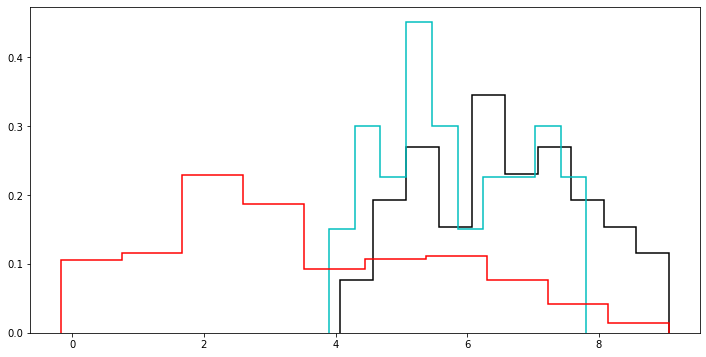

In [1689]:
plt.hist(np.log10(WDWD['P_in']),histtype='step',linewidth=1.5,color='black',density=True)
plt.hist(np.log10(WD_MS['P_in']),histtype='step',linewidth=1.5,color='c',density=True)

plt.hist(np.log10(df_final['P_in']),histtype='step',linewidth=1.5,color='red',density=True)

In [45]:
#3 changing (EKL off)
m1i = 1.100000e-01
m2i = 1.100000e-01
m3i = 20.
a2i = 8.000000e+03
a1i = 1.000000e+02


m1f = 1.100000e-01
m2f = 1.100000e-01
m3f = 2.269600e+00
a2f = 7.641886e+04
a1f = 1.000000e+02


# 1 	 2 	 120000300.000000 	9.000000e-01 	 1.000000e-01 	 -5.356356e-01 	 -2.380343e+00 	 1.000000e+02 	  
# 9.987163e+00 	  1.283263e-02   	  1.000000e+01 	  4.307566e+00 	  4.779300e+00 	  2.567099e+01 	  0.000000e+00 	 
# 1.464176e+00   	  1.463820e+00 	  2.507550e-07 	  -4.224931e-07 	  4.779300e+00 	  1.284600e+01 	  1.100000e-01 	
# 6.661559e-04  	  1.100000e-01 	 6.661559e-04 	 7.641886e+04 	 2.269600e+00 	 1.398840e-03 	 5.287283e-04 	
# 0.000000 	 0.000000 	 13.000000 	 5.853177e-06 	 4.499303e+01 	 5.909677e+01 	 END

# 1 	 2 	 120000300.000000 	9.000000e-01 	 1.000000e-01 	 -5.356356e-01 	 -2.380343e+00 	 1.000000e+02 	
# 9.992709e+01 	  7.291122e-02   	  1.000000e+02 	  4.307566e+00 	  4.779300e+00 	  2.567099e+01 	  0.000000e+00 	 
# 1.464177e+00   	  1.463818e+00 	  1.426626e-06 	  -2.403700e-06 	  4.779300e+00 	  1.284600e+01 	  1.100000e-01 	
# 6.661559e-04  	  1.100000e-01 	 6.661559e-04 	 7.641886e+04 	 2.269600e+00 	 1.398840e-03 	 5.287283e-04 	
# 0.000000 	 0.000000 	 13.000000 	 3.350450e-05 	 4.499298e+01 	 5.930524e+01 	 END

In [36]:
#1+3 changing
m1i = 2.000000e+01
m2i = 1.100000e-01
m3i = 5.000000e+00
a2i = 8.000000e+03
a1i = 1.000000e+02


m1f = 2.269597e+00
m2f = 1.100000e-01
m3f = 4.926137e+00
a2f = 2.773354e+04
a1f = 8.451011e+02

# 2 	 2 	 0.000000 	9.000000e-01 	 5.000000e-01 	 5.747428e+00 	 3.902843e+00 	 1.000000e+02 	  4.228244e+01 	
# 5.303452e-02   	  4.233548e+01 	  1.433873e+03 	  1.899065e-316 	  2.567099e+01 	  0.000000e+00 	  4.873256e+02   
# 4.873256e+02 	  0.000000e+00 	  0.000000e+00 	  4.779300e+00 	  1.228182e+02 	  2.000000e+01 	  2.789150e-02  	
# 1.100000e-01 	 6.661498e-04 	 8.000000e+03 	 5.000000e+00 	 0.000000e+00 	 4.914343e-03 	 1.000000 	 0.000000 
# 1.000000 	 0.000000e+00 	 4.500000e+01 	 4.500000e+01 	 FIRST

# 1 	 2 	 120000300.000000 	9.000000e-01 	 5.000000e-01 	 -5.279384e-01 	 -2.380343e+00 	 8.451011e+02 	
# 4.220927e+01 	  1.262081e-01   	  4.233548e+01 	  1.912347e+08 	  2.121454e+08 	  2.565301e+01 	  0.000000e+00 	 
# 6.561364e+07   	  6.426349e+07 	  3.074807e-03 	  -5.272745e-03 	  4.779296e+00 	  1.228182e+02 	  2.269597e+00 	  
# 6.508365e-08  	  1.100000e-01 	 6.661559e-04 	 2.773354e+04 	 4.926137e+00 	 1.101976e-07 	 2.335797e-08 	
# 13.000000 	 0.000000 	 4.000000 	 7.317424e-02 	 4.440439e+01 	 5.975136e+01 	 END

In [46]:
print( (m1i+m2i+m3i)*a2i - (m1f+m2f+m3f)*a2f )
print( (m1i+m2i)*a1i - (m1f+m2f)*a1f )


-28492.39385600001
0.0


In [350]:
#13
m1i = 2.032051e+01
m2i = 1.100000e-01
m3i = 2.000000e+01
a2i = 9.440055e+03
a1i = 6.739369e+01
Mi = m1i+m2i+m3i

m1f = 9.922626e+00
m2f = 1.100000e-01
m3f = 1.197969e+01  
a2f = 2.710173e+04
a1f = 1.372384e+02
Mf = m1f+m2f+m3f

dm1 = m1f-m1i
dm2 = m2f-m1f
dm3 = m3f-m3i

da1 = a1f-a1i
da2=a2f-a1f

In [114]:
a2i*(dm1+dm3) + (m1i+m2i+m3i)*da2

916319.3829180461

In [115]:
a2f*(dm1+dm3) + (m1f+m2f+m3f)*da2

94385.98900292558

In [ ]:
def get_final_periods(directory):
    #function to get final periods of all txt files in 'directory'
    #output in numpy array of logP in days

    for filename in os.listdir(directory):
        if filename.endswith('.txt') and filename.startswith('output'):
            this_file = os.path.join(directory, filename) #stores FULL filename

            first_line = get_first_line(this_file) #get first line
            last_line = get_last_line(this_file) #get last line
            
            N = filename.split('.txt')[0].split('_')[1] #get the output file number
            cut_folder = directory + 'cut_files/'
            if not os.path.isdir(cut_folder): #make cut_files directory if not alr there
                os.makedirs(cut_folder)
            with open(cut_folder+'first_last_{}.txt'.format(N), 'w') as f:
                f.write(first_line)
                f.write(last_line)

In [ ]:
#period of low mass binaries as a function of time -- El-Badry et al. 2022